In [1]:
import os
import cv2
from skimage import exposure
import numpy as np
import configparser
import matplotlib.pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, MaxPooling2D, Conv2D, Flatten, \
    BatchNormalization, Activation, GlobalAveragePooling2D, DepthwiseConv2D, \
    Dropout, ReLU, Concatenate, Input, add, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import split_dataset

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=6000)]
    )

logical_gpus = tf.config.list_logical_devices('GPU')
print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")

tf.config.run_functions_eagerly(True)
tf.keras.config.enable_interactive_logging()

1 Physical GPU, 1 Logical GPUs



# Iris tracker using CNN
## Load data
Load images of iris from CASIA-Iris-Degradation-Database

/home/davide/Scrivania/IUM/venv/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Example of image:
Shape of images: (75, 100, 1)
Example of label: [344. 222. 139.]
Shape of labels: (3,)


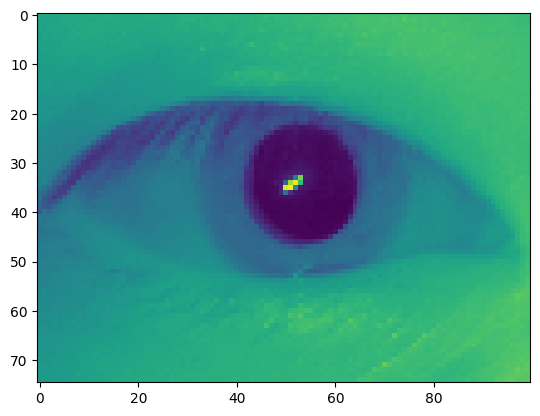

In [2]:
def parse_ini_file(file_path):
    file_path = file_path.numpy().decode('utf-8')
    
    # check if file exists
    if not os.path.exists(file_path):
        return [[0., 0., 0]]
    
    config = configparser.ConfigParser()
    config.read(file_path)
    return [[float(config['iris']['center_x']), float(config['iris']['center_y']), float(config['iris']['radius'])]]

def get_corr_ini_file(image_path):
    return image_path.numpy().decode('utf-8').replace('image', 'localization parameter').replace('.png', '.ini')

data = tf.data.Dataset.list_files('./dataset/CASIA-Iris-Degradation-Database/image/*.png', shuffle=False)

# foreach image, decode the image and find corresponding ini file with the same name and load the image and the ini file
labels = data.map(lambda x: tf.py_function(get_corr_ini_file, [x], tf.string), num_parallel_calls=tf.data.experimental.AUTOTUNE)
data = data.map(lambda x: tf.io.decode_png(tf.io.read_file(x), channels=1), num_parallel_calls=tf.data.experimental.AUTOTUNE)

initial_shape = data.as_numpy_iterator().next().shape

# rescale the image and the ini file
labels = labels.map(lambda x: tf.py_function(parse_ini_file, [x], [tf.float16]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
data = data.map(lambda x: tf.image.resize(x, [100, 100], preserve_aspect_ratio=True) / 255, num_parallel_calls=tf.data.experimental.AUTOTUNE)

new_shape = data.as_numpy_iterator().next().shape

# set shape of labels
labels = labels.map(lambda x: tf.ensure_shape(x, [3]), num_parallel_calls=tf.data.experimental.AUTOTUNE)

# set 3 channels for the image
# data = data.map(lambda x: tf.tile(x, [1, 1, 3]))

print("Example of image:")
plt.imshow(data.as_numpy_iterator().next())

print("Shape of images: " + str(data.as_numpy_iterator().next().shape))
print("Example of label: " + str(labels.as_numpy_iterator().next()))
print("Shape of labels: " + str(labels.as_numpy_iterator().next().shape))

Link toghether images and labels having same name

In [3]:
dataset = tf.data.Dataset.zip((data, labels))

## Data augmentation

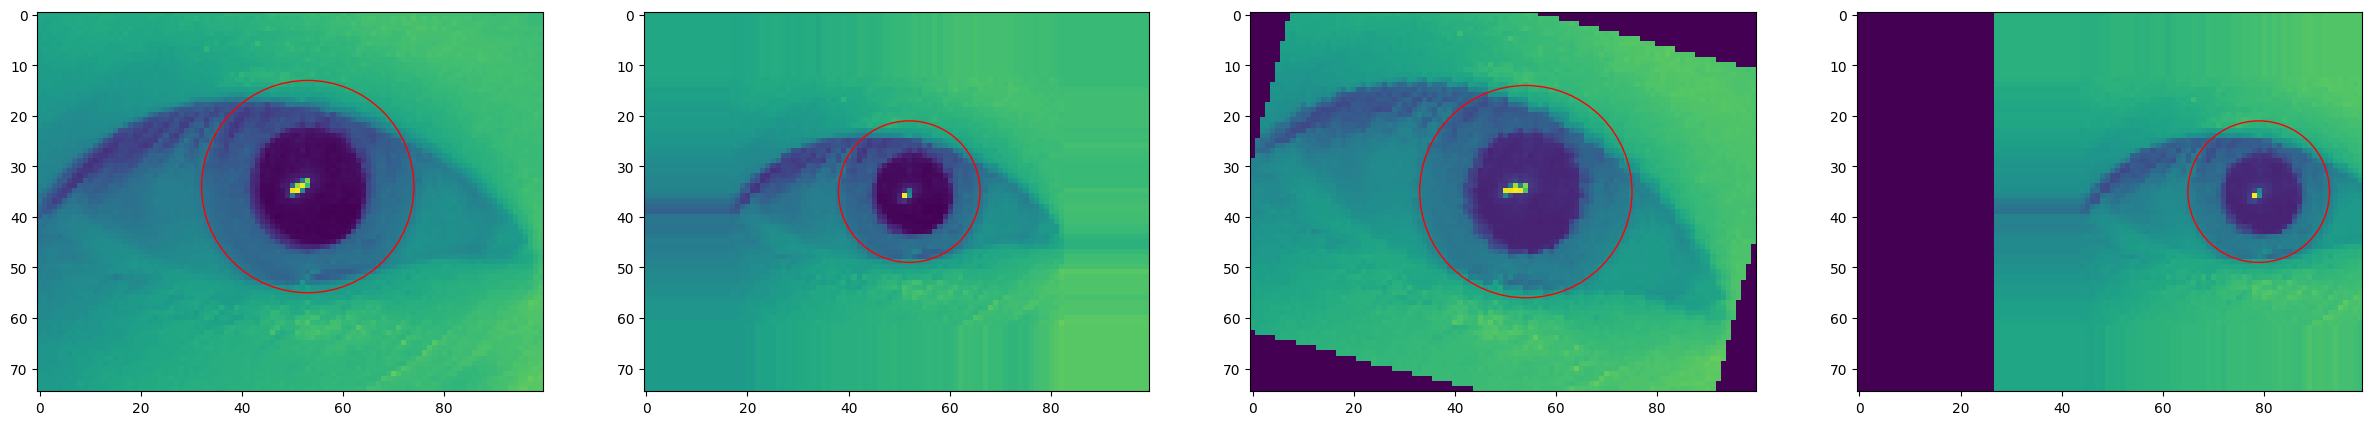

In [4]:
# random zoom, fill mode is border replicate 
def random_zoom_out(image, landmarks, zoom_range=(0.5, 0.9), shape=(96, 96)):
    if type(image) != np.ndarray:
        image = image.numpy()
        
    if type(landmarks) != np.ndarray:
        landmarks = landmarks.numpy()
        
    if type(shape) != tuple:
        shape = shape.numpy()
        
    if type(zoom_range) != tuple:
        zoom_range = zoom_range.numpy()
    
    zoom = np.random.uniform(zoom_range[0], zoom_range[1])
    new_size = (int(image.shape[1] * zoom), int(image.shape[0] * zoom))
    diff_x = shape[0] - new_size[1]
    diff_y = shape[1] - new_size[0]

    image_zoomed = cv2.resize(image, new_size, interpolation=cv2.INTER_NEAREST)

    diff_1 = diff_x // 2
    diff_2 = diff_y // 2
    diff_3 = diff_1 + diff_x % 2
    diff_4 = diff_2 + diff_y % 2
    
    image_zoomed = cv2.copyMakeBorder(image_zoomed, diff_1, diff_3, diff_2, diff_4, cv2.BORDER_REPLICATE)
    
    landmarks_zoomed = np.copy(landmarks)
    landmarks_zoomed[0] = landmarks[0] * (initial_shape[0] * zoom) / initial_shape[0] + (initial_shape[1] - initial_shape[1] * zoom) / 2
    landmarks_zoomed[1] = landmarks[1] * (initial_shape[0] * zoom) / initial_shape[0] + (initial_shape[0] - initial_shape[0] * zoom) / 2
    landmarks_zoomed[2] = landmarks[2] * zoom

    if image_zoomed.shape[0] != shape[0] or image_zoomed.shape[1] != shape[1]:
        print('image_zoomed shape:', image_zoomed.shape)
        raise Exception('Invalid shape')

    return np.expand_dims(image_zoomed, axis=2), landmarks_zoomed

# random rotation
def random_rotation(image, landmarks, angle_range=(-30, 30)):
    if type(image) != np.ndarray:
        image = image.numpy()
        
    if type(landmarks) != np.ndarray:
        landmarks = landmarks.numpy()
        
    if type(angle_range) != tuple:
        angle_range = angle_range.numpy()
            
    angle = np.random.uniform(angle_range[0], angle_range[1])
    center = (image.shape[1] // 2, image.shape[0] // 2)
    rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)

    image_rotated = cv2.warpAffine(image, rot_mat, (image.shape[1], image.shape[0]), flags=cv2.INTER_NEAREST)

    landmarks_rotated = np.copy(landmarks)
    x = landmarks[0]
    y = landmarks[1]

    center = (initial_shape[1] // 2, initial_shape[0] // 2)
    rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)
    
    landmarks_rotated[0] = rot_mat[0, 0] * x + rot_mat[0, 1] * y + rot_mat[0, 2]
    landmarks_rotated[1] = rot_mat[1, 0] * x + rot_mat[1, 1] * y + rot_mat[1, 2]

    return np.expand_dims(image_rotated, axis=2), landmarks_rotated

# random shift, choose a random shift value and a random direction
def random_shift(image, landmarks, shift_range=(0, 30)):
    if type(image) != np.ndarray:
        image = image.numpy()
        
    if type(landmarks) != np.ndarray:
        landmarks = landmarks.numpy()
        
    if type(shift_range) != tuple:
        shift_range = shift_range.numpy()
    
    shift = int(np.random.uniform(shift_range[0], shift_range[1]))
    direction = np.random.choice(['left', 'right', 'up', 'down'])

    if direction == 'left':
        shift_x = -shift
        shift_y = 0
    elif direction == 'right':
        shift_x = shift
        shift_y = 0
    elif direction == 'up':
        shift_x = 0
        shift_y = -shift
    else:
        shift_x = 0
        shift_y = shift

    shift_mat = np.float32([[1, 0, shift_x], [0, 1, shift_y]])
    image_shifted = cv2.warpAffine(image, shift_mat, (image.shape[1], image.shape[0]), flags=cv2.INTER_NEAREST)

    landmarks_shifted = np.copy(landmarks)
    landmarks_shifted[0] += shift_x * initial_shape[0] / image.shape[0]
    landmarks_shifted[1] += shift_y * initial_shape[1] / image.shape[1]

    return np.expand_dims(image_shifted, axis=2), landmarks_shifted

# example of data augmentation
image, iris_coords = dataset.as_numpy_iterator().next()

image_zoomed, coord_zoomed = random_zoom_out(image, iris_coords, shape=(new_shape[0], new_shape[1]))
image_rotated, coord_rotated = random_rotation(image, iris_coords)
image_shifted, coord_shifted = random_shift(image_zoomed, coord_zoomed)

fig, ax = plt.subplots(ncols=4, figsize=(30,30))
ax[0].imshow(image)
ax[1].imshow(image_zoomed)
ax[2].imshow(image_rotated)
ax[3].imshow(image_shifted)

circle = plt.Circle((int(iris_coords[0] * image.shape[0] / initial_shape[0]), int(iris_coords[1] * image.shape[1] / initial_shape[1])), int(iris_coords[2] * image.shape[0] / initial_shape[0]), color='r', fill=False)

circle_zoomed = plt.Circle((int(coord_zoomed[0] * image_zoomed.shape[0] / initial_shape[0]), int(coord_zoomed[1] * image_zoomed.shape[1] / initial_shape[1])), int(coord_zoomed[2] * image_zoomed.shape[0] / initial_shape[0]), color='r', fill=False)

circle_rotated = plt.Circle((int(coord_rotated[0] * image_rotated.shape[0] / initial_shape[0]), int(coord_rotated[1] * image_rotated.shape[1] / initial_shape[1])), int(coord_rotated[2] * image_rotated.shape[0] / initial_shape[0]), color='r', fill=False)

circle_shifted = plt.Circle((int(coord_shifted[0] * image_shifted.shape[0] / initial_shape[0]), int(coord_shifted[1] * image_shifted.shape[1] / initial_shape[1])), int(coord_shifted[2] * image_shifted.shape[0] / initial_shape[0]), color='r', fill=False)
                            
ax[0].add_artist(circle)
ax[1].add_artist(circle_zoomed)
ax[2].add_artist(circle_rotated)
ax[3].add_artist(circle_shifted)

Apply data augmentation to the dataset

In [5]:
# choose a random subset of the dataset and apply data augmentation
def augment_dataset(dataset, size=1000):
    augmented_dataset = tf.data.Dataset.sample_from_datasets([dataset]).take(size)
    augmented_dataset_1 = augmented_dataset.map(lambda x, y: tf.py_function(random_zoom_out, [x, y, (0.5, 0.9), (new_shape[0], new_shape[1])], [tf.float32, tf.float16]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    augmented_dataset_2 = augmented_dataset.map(lambda x, y: tf.py_function(random_rotation, [x, y], [tf.float32, tf.float16]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    augmented_dataset_3 = augmented_dataset_1.map(lambda x, y: tf.py_function(random_rotation, [x, y], [tf.float32, tf.float16]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return augmented_dataset_1.concatenate(augmented_dataset_2).concatenate(augmented_dataset_3)

augmented_dataset = augment_dataset(dataset, 10000)
dataset = dataset.concatenate(augmented_dataset)

In [6]:
# ensure shape of the dataset
dataset = dataset.map(lambda x, y: (tf.ensure_shape(x, [new_shape[0], new_shape[1], 1]), tf.ensure_shape(y, [3])), num_parallel_calls=tf.data.experimental.AUTOTUNE)

## Divide dataset into train, test and validation

In [7]:
train_size = int(0.7 * len(dataset))
test_size = int(0.15 * len(dataset))
val_size = len(dataset) - train_size - test_size

# use tf.keras.utils.split_dataset to split the dataset into train, test and validation
train_dataset, test_val_dataset = split_dataset(dataset, train_size, test_size + val_size, shuffle=True, seed=42)
test_dataset = test_val_dataset.take(test_size)
val_dataset = test_val_dataset.skip(test_size)

print("Train size: " + str(len(train_dataset)))
print("Test size: " + str(len(test_dataset)))
print("Validation size: " + str(len(val_dataset)))

Train size: 46577
Test size: 9980
Validation size: 9982


## Shuffle, batch and prefetch the datasets

In [8]:
train_dataset = train_dataset.shuffle(1000).batch(64, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.shuffle(1000).batch(64, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(1000).batch(64, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False).prefetch(tf.data.AUTOTUNE)

## Show some examples

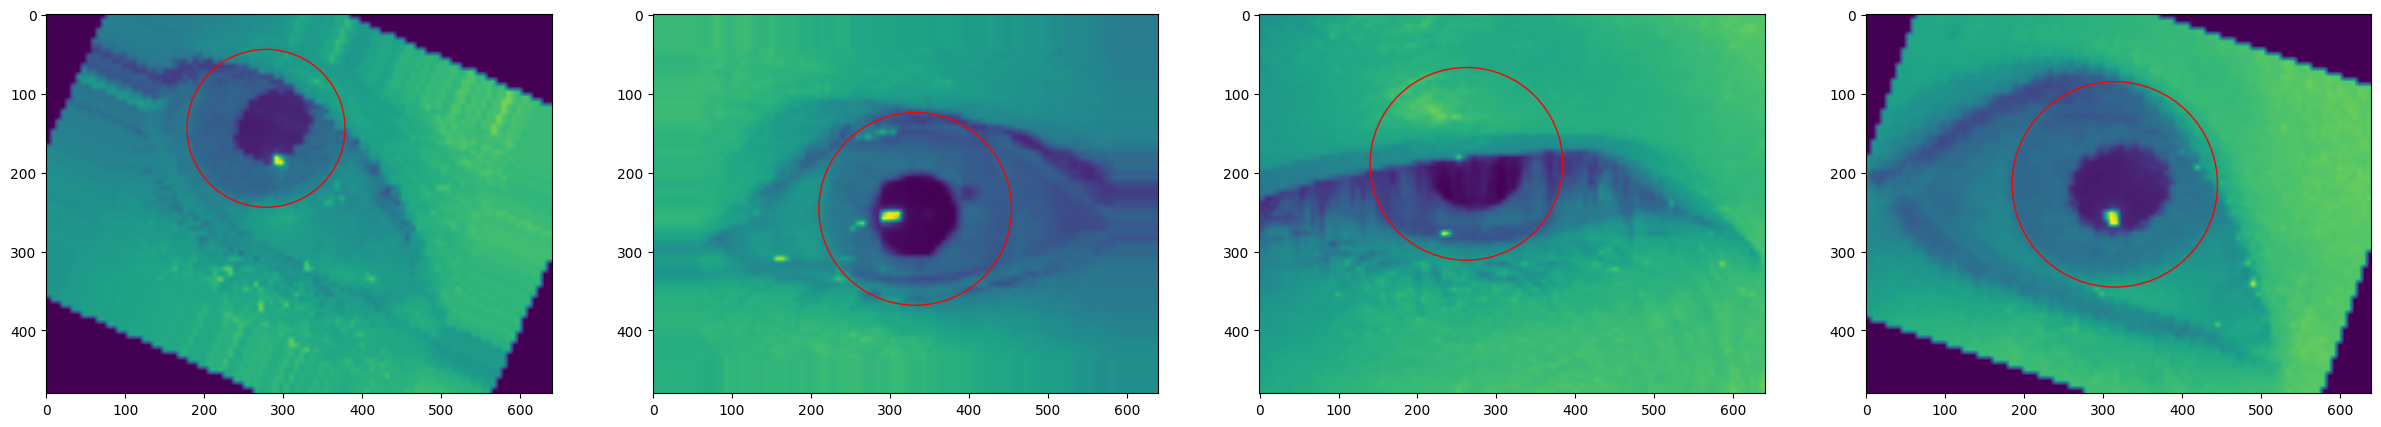

In [9]:
res = train_dataset.as_numpy_iterator().next()

fig, ax = plt.subplots(ncols=4, figsize=(30,30))
for idx in range(4):
    image = np.copy(res[0][idx])
    iris_coords = res[1][idx]
    
    image = cv2.resize(image, (initial_shape[1], initial_shape[0]))

    circle = plt.Circle((int(iris_coords[0]), int(iris_coords[1])), int(iris_coords[2]), color='r', fill=False)

    ax[idx].imshow(image)
    ax[idx].add_artist(circle)

# Create the model

In [10]:
input_ = Input(shape=new_shape)

# level 1
b1_bn_1 = BatchNormalization()(input_)
b1_c2D_1 = Conv2D(128, (3, 3), padding='same', activation='relu')(b1_bn_1)
b1_mp_1 = MaxPooling2D(pool_size=(2, 2))(b1_c2D_1)
b1_out = Dropout(0.15)(b1_mp_1)

b1_res_c2D_1 = Conv2D(128, (1, 1), padding='same', activation='relu')(b1_out)
b1_res_bn_1 = BatchNormalization()(b1_res_c2D_1)

# add residual connection
b1_add = add([b1_out, b1_res_bn_1])

# level 2
b2_bn_1 = BatchNormalization()(b1_add)
b2_cnv2d_1 = Conv2D(256, (3, 3), padding='same', activation='relu')(b2_bn_1)
b2_mp_1 = MaxPooling2D(pool_size=(2, 2))(b2_cnv2d_1)
b2_out = Dropout(0.25)(b2_mp_1)

b2_res_c2D_1 = Conv2D(256, (1, 1), padding='same', activation='relu')(b2_out)
b2_res_bn_1 = BatchNormalization()(b2_res_c2D_1)

# add residual connection
b2_add = add([b2_out, b2_res_bn_1])

# level 3
b3_bn_1 = BatchNormalization()(b2_add)
b3_cnv2d_1 = Conv2D(512, (3, 3), padding='same', activation='relu')(b3_bn_1)
b3_mp_1 = MaxPooling2D(pool_size=(2, 2))(b3_cnv2d_1)
b3_out = Dropout(0.15)(b3_mp_1)

b3_res_c2D_1 = Conv2D(512, (1, 1), padding='same', activation='relu')(b3_out)
b3_res_bn_1 = BatchNormalization()(b3_res_c2D_1)

# add residual connection
b3_add = add([b3_out, b3_res_bn_1])

# level 4
b5_bn_1 = BatchNormalization()(b3_add)
b5_cnv2d_1 = Conv2D(256, 2, 2, padding='same', activation='relu')(b5_bn_1)
b5_cnv2d_2 = Conv2D(128, 2, 2, activation='relu')(b5_cnv2d_1)
b5_cnv2d_4 = Conv2D(32, 2, 2, activation='relu')(b5_cnv2d_2)
b5_cnv2d_5 = Conv2D(3, 1, 1, activation='relu')(b5_cnv2d_4)
b5_reshape = Reshape((3,))(b5_cnv2d_5)

model = Model(inputs=input_, outputs=b5_reshape)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 75, 100,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 75, 100,   │          4 │ input_layer[0][0] │
│ (BatchNormalizatio… │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 75, 100,   │      1,280 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 37, 50,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 37, 50,    │          0 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 37, 50,    │     16,512 │ dropout[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 37, 50,    │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 37, 50,    │          0 │ dropout[0][0],    │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 37, 50,    │        512 │ add[0][0]         │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 37, 50,    │    295,168 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 18, 25,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 18, 25,    │          0 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 18, 25,    │     65,792 │ dropout_1[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 18, 25,    │      1,024 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 18, 25,    │          0 │ dropout_1[0][0],  │
│                     │ 256)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 18, 25,    │      1,024 │ add_1[0][0]       │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 18, 25,    │  1,180,160 │ batch_normalizat

 Total params: 2,500,999 (9.54 MB)

 Trainable params: 2,497,413 (9.53 MB)

 Non-trainable params: 3,586 (14.01 KB)

## Losses and optimizer

In [11]:
# early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=25,
    verbose=1,
    restore_best_weights=True
)

model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['accuracy', 'mae'])

In [12]:
X, y = train_dataset.as_numpy_iterator().next()
X.shape

(64, 75, 100, 1)

In [13]:
scores = model.predict(X)
scores

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


array([[0.02610153, 0.        , 0.        ],
       [0.03125857, 0.        , 0.        ],
       [0.02299962, 0.        , 0.        ],
       [0.02505379, 0.        , 0.        ],
       [0.02898973, 0.        , 0.        ],
       [0.03522749, 0.00270097, 0.        ],
       [0.0268118 , 0.        , 0.        ],
       [0.02015721, 0.        , 0.        ],
       [0.04544965, 0.01815179, 0.        ],
       [0.02222927, 0.        , 0.        ],
       [0.02619663, 0.        , 0.        ],
       [0.02434471, 0.        , 0.        ],
       [0.01954493, 0.        , 0.        ],
       [0.03092887, 0.        , 0.        ],
       [0.02220535, 0.        , 0.        ],
       [0.0157228 , 0.        , 0.        ],
       [0.0180905 , 0.        , 0.        ],
       [0.02703712, 0.        , 0.        ],
       [0.01127781, 0.        , 0.        ],
       [0.01401864, 0.        , 0.        ],
       [0.01515741, 0.        , 0.        ],
       [0.02959686, 0.        , 0.        ],
       [0.

# Train the model

In [14]:
# Train for 100 epochs
hist = model.fit(
    train_dataset, 
    epochs=100, 
    shuffle=True,
    validation_data=val_dataset,
    callbacks=[early_stopping]
)   

Epoch 1/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 161s 215ms/step - accuracy: 0.9430 - loss: 8807.8223 - mae: 66.6872 - val_accuracy: 0.9404 - val_loss: 6318.0469 - val_mae: 56.5020
Epoch 2/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 156s 215ms/step - accuracy: 0.9620 - loss: 5647.3999 - mae: 48.6740 - val_accuracy: 0.9738 - val_loss: 5614.4043 - val_mae: 47.4440
Epoch 3/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 159s 219ms/step - accuracy: 0.9709 - loss: 5009.5908 - mae: 43.8089 - val_accuracy: 0.9762 - val_loss: 628.2599 - val_mae: 13.5722
Epoch 4/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 160s 220ms/step - accuracy: 0.9784 - loss: 466.8998 - mae: 11.3165 - val_accuracy: 0.9621 - val_loss: 602.0142 - val_mae: 12.5707
Epoch 5/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 160s 220ms/step - accuracy: 0.9784 - loss: 402.5626 - mae: 10.2990 - val_accuracy: 0.9848 - val_loss: 555.2514 - val_mae: 13.4562
Epoch 6/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 158s 218ms/step - accuracy: 0.9804 - loss: 355.5831 - mae: 9.3857 - val_accuracy: 0.9850 - val_loss

## Model evaluation
save and load model from file

In [15]:
model.save('./models/iris_tracker_residual.h5')

In [16]:
model = tf.keras.models.load_model('./models/iris_tracker_residual.h5')

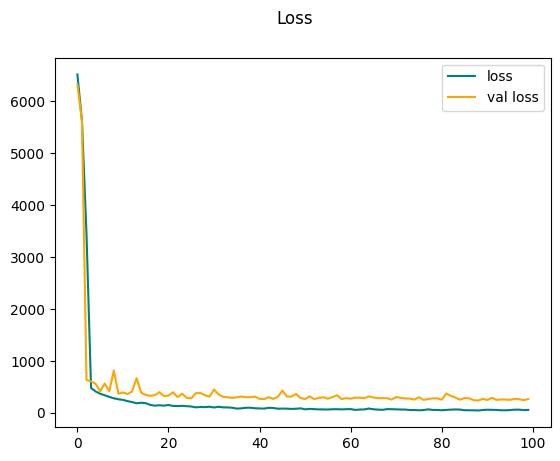

In [17]:
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val loss')
plt.suptitle('Loss')
plt.legend()
plt.show()

In [18]:
model.evaluate(test_dataset)

156/156 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9948 - loss: 283.4295 - mean_absolute_error: 4.9103


[304.75225830078125, 0.9943887591362, 4.9767608642578125]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


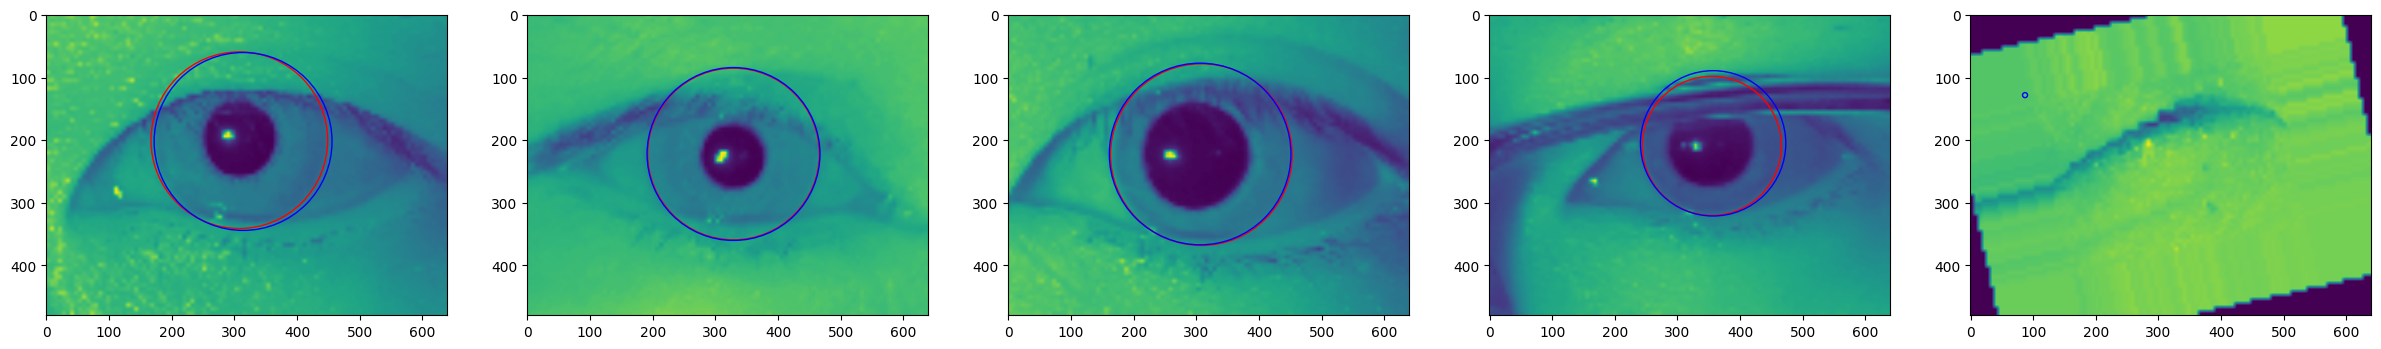

In [19]:
test = test_dataset.shuffle(5000).as_numpy_iterator().next()
pred = model.predict(test[0])

fig, ax = plt.subplots(ncols=5, figsize=(30,30))
for idx in range(5):
    image = np.copy(test[0][idx])
    iris_coords = test[1][idx]  
    pred_coords = pred[idx]
    
    image = cv2.resize(image, (initial_shape[1], initial_shape[0]))

    circle = plt.Circle((int(iris_coords[0]), int(iris_coords[1])), int(iris_coords[2]), color='r', fill=False)
    pred_circle = plt.Circle((int(pred_coords[0] * image.shape[0] / initial_shape[0]), int(pred_coords[1] * image.shape[1] / initial_shape[1])), int(pred_coords[2] * image.shape[0] / initial_shape[0]), color='b', fill=False)

    ax[idx].imshow(image)
    ax[idx].add_artist(circle)
    ax[idx].add_artist(pred_circle)

create a coordinate converter for other images

In [20]:
def predict_iris(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    original_shape = image.shape
    image = cv2.resize(image, (new_shape[1], new_shape[0]))
    image = image / 255.0
        
    pred = model.predict(image.reshape(1, new_shape[0], new_shape[1], 1))
    
    pred[0][0] = pred[0][0] * original_shape[0] / initial_shape[0]
    pred[0][1] = pred[0][1] * original_shape[1] / initial_shape[1]
    pred[0][2] = pred[0][2] * original_shape[0] / initial_shape[0]
    return pred[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[273.75864 161.98979  88.65616]


/home/davide/Scrivania/IUM/venv/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


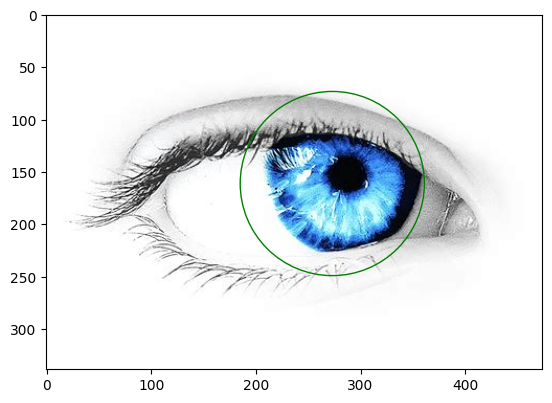

In [24]:
image_path = './dataset/test.jpg'
pred = predict_iris(image_path)
print(pred)

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots()
circle = plt.Circle((int(pred[0]), int(pred[1])), int(pred[2]), color='g', fill=False)
ax.imshow(image)
ax.add_artist(circle)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[ 85.64991  101.27999   48.917896]


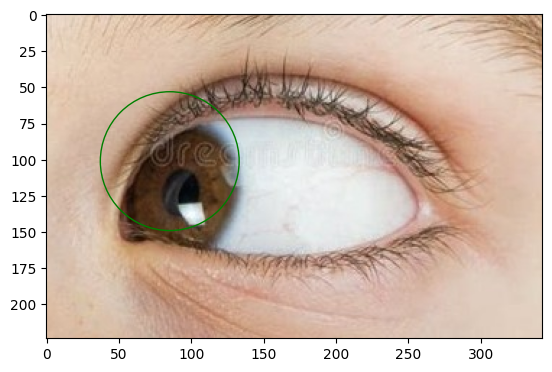

In [22]:
image_path = './dataset/test_2.jpg'
pred = predict_iris(image_path)
print(pred)

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots()
circle = plt.Circle((int(pred[0]), int(pred[1])), int(pred[2]), color='g', fill=False)
ax.imshow(image)
ax.add_artist(circle)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[204.71823  162.60905   63.854248]


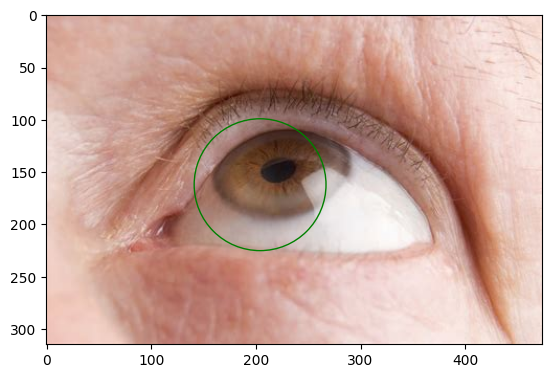

In [23]:
image_path = './dataset/test_3.jpg'

pred = predict_iris(image_path)
print(pred)

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots()
circle = plt.Circle((int(pred[0]), int(pred[1])), int(pred[2]), color='g', fill=False)
ax.imshow(image)
ax.add_artist(circle)